[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorisRoels/deep-learning-biology/blob/main/exercises/solutions/2020-dlb-3-cnn-segmentation-solution.ipynb)

# Exercise 3: Convolutional neural networks for segmentation

In this notebook, we will be using convolutional neural networks for segmentation of neurons in electron microscopy data. 

The structure of these exercises is as follows: 

1. [Import libraries and download data](#scrollTo=ScagUEMTMjlK)
2. [Data visualization and pre-processing](#scrollTo=ohZHyOTnI35b)
3. [Segmentation: a pixel classification problem](#scrollTo=UyspYtez5J8a)
4. [Building a U-Net with PyTorch](#scrollTo=wXbjn29WOOJ3)
5. [Training & validating the network](#scrollTo=zh8Pf_3HF_hi)

This notebook is largely based on the research published in: 

Arganda-Carreras, I., Turaga, S. C., Berger, D. R., Ciresan, D. C., Giusti, A., Gambardella, L. M., Schmidhuber, J., Laptev, D., Dwivedi, S., Buhmann, J. M., Liu, T., Seyedhosseini, M., Tasdizen, T., Kamentsky, L., Burget, R., Uher, V., Tan, X., Sun, C., Pham, T. D., … Seung, H. S. (2015). Crowdsourcing the creation of image segmentation algorithms for connectomics. Frontiers in Neuroanatomy, 9. https://doi.org/10.3389/fnana.2015.00142

## 1. Import libraries and download data
Let's start with importing the necessary libraries. 

In [1]:
!pip install neuralnets

     |████████████████████████████████| 61kB 8.7MB/s 
  Created wheel for progress: filename=progress-1.5-cp36-none-any.whl size=8074 sha256=5a74fcb22156810461bcdf53708811bb1cb3f36e898ab3dcc93d5f0d66e54bde
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress


In [2]:
import pickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
plt.rcdefaults()
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets
import gdown
import zipfile
import os
import progressbar
import time

from neuralnets.util.io import read_tif
from neuralnets.util.visualization import overlay

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [3]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


We will now download the required data from a public Google Drive repository. The data is stored as a zip archive and automatically extracted to the `data` directory in the current directory. 

In [4]:
# fields
url = 'http://data.bits.vib.be/pub/trainingen/DeepLearning/data-3.zip'
cmp_data_path = 'data.zip'

# download the compressed data
gdown.download(url, cmp_data_path, quiet=False)

# extract the data
zip = zipfile.ZipFile(cmp_data_path)
zip.extractall('')

# remove the compressed data
os.remove(cmp_data_path)

Downloading...
From: http://data.bits.vib.be/pub/trainingen/DeepLearning/data-3.zip
To: /content/data.zip
100%|██████████| 14.9M/14.9M [00:01<00:00, 12.7MB/s]


## 2. Data visualization and pre-processing

The data used for this exercise session originates from an ISBI segmentation challenge on neuron structures in electron microscopy image stacks. The organizers provide a training volume and their corresponding labels. The test set is also provided, however predictions can be validated by uploading them to the challenge central server. This is to avoid overfitting the model on the test set. 

Each data volume is provided as a .tif file that contains a 3D array. For the input data, these are simply the intensity values measured by the microscope. For the labels, this is a binary value: 0 for membrane, 255 for inner neuron structure. 

We briefly visualize the labeled data. 

Size of the labeled volume: 30 x 512 x 512


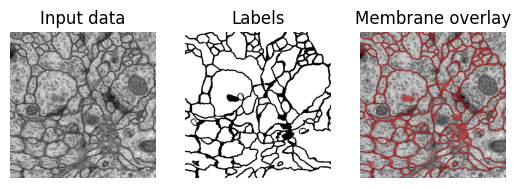

In [5]:
# specify where the data is stored
data_dir = 'data-3'

# load the datadispensers
x = read_tif(os.path.join(data_dir, 'train-volume.tif'))
y = read_tif(os.path.join(data_dir, 'train-labels.tif'))

# print out size
print('Size of the labeled volume: %d x %d x %d' % x.shape)

# show example
x_overlay = overlay(x[0] / 255, 1-(y[0]>0), colors=[(1, 0, 0)], alpha=0.4)
plt.subplot(1, 3, 1)
plt.imshow(x[0], cmap='gray')
plt.title('Input data')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(y[0], cmap='gray')
plt.title('Labels')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(x_overlay)
plt.title('Membrane overlay')
plt.axis('off')
plt.show()

Annotation of datasets like this typically involve lots of expertise and manual labour and is therefore extremely costly. This is a general issue in biomedical image-based datasets. For this reason, there has been increasing attention in developing automated segmentation techniques for biomedical imaging datasets. In the following, you will see how deep learning models can achieve relatively high accuracy on complex task such as neuronal structure segmentation. 

As in practically any image analysis application, it is good common practice to rescale the data to the [0,1] interval, map the labels to subsequent values (0 and 1 in this case) and split the data in a train and test set. 

In [6]:
# normalize the data
x = (x - np.min(x)) / (np.max(x) - np.min(x))

# map the 255 labels to 1
y[y == 255] = 1

# split the data in a train and test set
test_ratio = 0.33 # we will use 33% of the data for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=seed)

# print out size
print('Training volume: %d x %d x %d' % x_train.shape)
print('Testing volume: %d x %d x %d' % x_test.shape)

# 
class_distribution = [np.sum(y_train == 0) / y_train.size, np.sum(y_train == 1) / y_train.size]
print('Class balance: ' )
print('    0: %.3f' % class_distribution[0])
print('    1: %.3f' % class_distribution[1])

Training volume: 20 x 512 x 512
Testing volume: 10 x 512 x 512
Class balance: 
    0: 0.221
    1: 0.779


## 3. Segmentation: a pixel classification problem

From a machine learning point of view, image segmentation can be seen as a classification problem. For each pixel in the image, the goal is to predict the corresponding class (membrane or non-membrane). Up to 2012, most techniques were based on extracting a set of features from a local or global region (e.g. intensity, edges, etc.) around the pixel and training a shallow classifier (e.g. a random forest). The choice of features would typically be the crucial factor and is different for each application. 

Convolutional neural networks however, are able to solve this issue, as the feature extractor is learned based on the training data. To do this, we have to do two things: implement a dataset that extracts a local window for each pixel and train a CNN that performs binary classification. Let's start with the dataset. 

**Exercise**: Implement the `EMWindowDataset` class:  
- The `__init__` function should save the inputs and labels
- The `__getitem__` function should return a local window around the i'th pixel (use slice-by-slice raster ordering for this) and the corresponding label of that pixel. Note that extracting local windows near the bounds of the image may result in out-of-bound errors. You can omit this by [padding](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) the data. 
- The `__len__` function should ideally return the amount of pixels in the data. However, a single epoch would then require lots of iterations. Cap this with an upper bound `max_iter_epoch`. 
- Data augmentation is not yet required. 




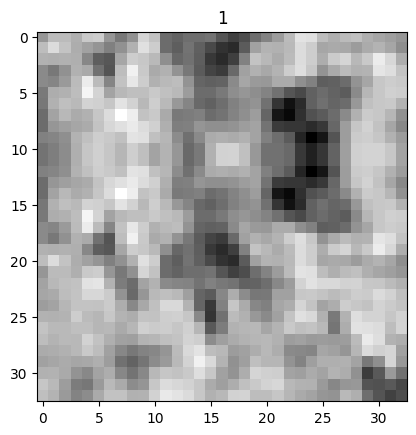

In [7]:
# helper function: transform a linear index from a 3D array to 3D coordinates
# assuming slice-by-slice raster scanning ordering
def delinearize_index(i, sz):
    z_, y_, x_ = sz
    x = np.mod(i, x_)
    j = (i - x) // x_
    y = np.mod(j, y_)
    z = (j - y) // y_
    return z, y, x

# dataset useful for sampling (and many other things)
class EMWindowDataset(data.Dataset):
    
    def __init__(self, x, y, wnd_sz, max_iter_epoch):

        # window size
        self.wnd_sz = wnd_sz

        # offset (for padding)
        self.offset = (wnd_sz[0] // 2, wnd_sz[1] // 2)
        
        # size of the data
        self.size = x.shape

        # maximum number of iterations per epoch
        self.max_iter_epoch = max_iter_epoch

        # pad the data to avoid boundary issues
        self.x_padded = np.pad(x, ((0, 0), (self.offset[0], self.offset[0]), (self.offset[1], self.offset[1])), 'symmetric')

        # save the labels, no padding required
        self.y = y
    
    def __getitem__(self, i):

        # delinearize the index
        z, y, x = delinearize_index(i, self.size)

        # extract the window, don't forget the offsets
        oy, ox = self.offset
        wnd = self.x_padded[z:z + 1, y:y + 2 * oy + 1, x:x + 2 * ox + 1]

        return wnd, self.y[z, y, x]
    
    def __len__(self):
        return self.max_iter_epoch

# parameters
window_size = (32, 32)
batch_size = 256
max_iter_epoch = 2**12

# make an instance of the dataset for training and testing
ds_train = EMWindowDataset(x_train, y_train, window_size, max_iter_epoch)
ds_test = EMWindowDataset(x_test, y_test, window_size, max_iter_epoch)

# test the class
n = np.random.randint(len(ds_train))
wnd, label = ds_train[n]
plt.imshow(wnd[0], cmap='gray')
plt.title(label)
plt.show()

# setup the data loader
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

The positive side to segmentation labels is that each pixel corresponds to a single annotation. In contrast to usual classification dataset, this may give the impression that there are lots of labels. However, keep in mind that the data is heavily correlated, especially locally. In other words, neighboring pixel labels of a reference pixel won't provide that much more information than the reference pixel label. 

The classification network that we will use is exactly the same as the one we used in the previous session. 

In [8]:
class ConvNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvNormRelu, self).__init__()
        self.unit = nn.Sequential()
        self.unit.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        self.unit.add_module('norm', nn.BatchNorm2d(int(out_channels)))
        self.unit.add_module('activation', nn.ReLU())

    def forward(self, inputs):
        return self.unit(inputs)

class CNN(nn.Module):
    def __init__(self, feature_maps=16):
        super(CNN, self).__init__()

        self.feature_maps = feature_maps

        self.conv1 = ConvNormRelu(in_channels=1, out_channels=feature_maps)
        self.conv2 = ConvNormRelu(in_channels=feature_maps, out_channels=feature_maps)
        self.conv3 = ConvNormRelu(in_channels=feature_maps, out_channels=feature_maps)
        self.conv4 = ConvNormRelu(in_channels=feature_maps, out_channels=feature_maps)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(feature_maps*2*2, 2)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.pool(self.conv4(x))
        x = x.view(-1, self.feature_maps*2*2)
        x = self.fc(x)
        return x


net = CNN(feature_maps=16)
print(net)

CNN(
  (conv1): ConvNormRelu(
    (unit): Sequential(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
  )
  (conv2): ConvNormRelu(
    (unit): Sequential(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
  )
  (conv3): ConvNormRelu(
    (unit): Sequential(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
  )
  (conv4): ConvNormRelu(
    (unit): Sequential(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats

We will use an alternative metric for validation. The accuracy is a metric motivated from a classification point of view. A more suitable segmentation metric is the Dice coefficient: 

$$
D = \frac{2 \times \left| Y \cap \hat{Y} \right|}{\left| Y \right| + \left| \hat{Y} \right|}
$$

where $Y$ and $\hat{Y}$ are the ground truth and predicted segmentation, respectively. If the prediction perfectly overlaps, the Dice coefficient will be 1. The code below illustrates the resulting segmentation of the best model so far and the corresponding dice score. 

**Exercise**: Train the classification network for pixel-wise label prediction:  
- Implement the `train_net`, `train_epoch` and `test_epoch`. To make life easier, you can reuse parts of the code of the previous exercise. 
- Implement the `dice` function that computes the metric describe above. Save the model with the highest Dice score (averaged over the two classes). 
- Evaluate the (average) Dice metric at the end of each test epoch and save it, so that it can be plotted (similar to the loss). 
- Train the network for 20 epochs at a learning rate of 0.001. 

Epoch     0 - Train loss: 0.414006 - Test loss: 0.693262 - Test dice avg: 0.441277
Epoch     1 - Train loss: 0.230934 - Test loss: 0.721943 - Test dice avg: 0.497957
Epoch     2 - Train loss: 0.161893 - Test loss: 0.673282 - Test dice avg: 0.692215
Epoch     3 - Train loss: 0.119127 - Test loss: 0.639826 - Test dice avg: 0.738619
Epoch     4 - Train loss: 0.091824 - Test loss: 0.601032 - Test dice avg: 0.754433
Epoch     5 - Train loss: 0.075326 - Test loss: 0.657208 - Test dice avg: 0.755952
Epoch     6 - Train loss: 0.062996 - Test loss: 0.788308 - Test dice avg: 0.739927
Epoch     7 - Train loss: 0.054004 - Test loss: 0.871502 - Test dice avg: 0.744548
Epoch     8 - Train loss: 0.043278 - Test loss: 0.694500 - Test dice avg: 0.766866
Epoch     9 - Train loss: 0.039117 - Test loss: 0.965212 - Test dice avg: 0.726596
Epoch    10 - Train loss: 0.030984 - Test loss: 0.829635 - Test dice avg: 0.747853
Epoch    11 - Train loss: 0.029167 - Test loss: 0.869089 - Test dice avg: 0.745000
Epoc

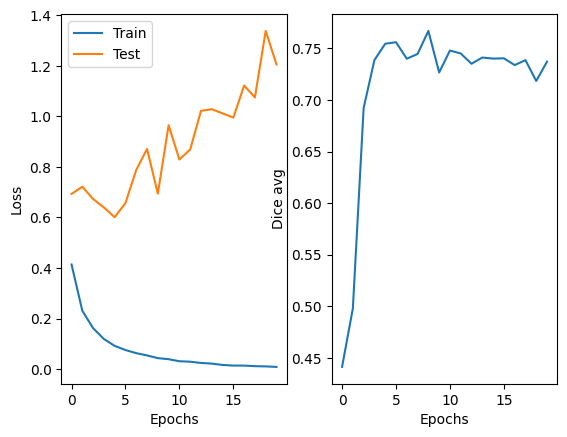

In [9]:
# dice coefficient implementation
def dice(y, y_pred):
    intersection = np.sum(y * y_pred)
    return 2 * intersection / (np.sum(y) + np.sum(y_pred))

# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer):
    
    # set the network in training mode
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data

        # transfer data to GPU and correct format
        x = x.float().to(device)
        y = y.long().to(device)
        
        # set all gradients equal to zero
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
        
        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in training mode
    net.eval()
    
    # keep track of the loss and predictions
    preds = np.zeros((len(loader.dataset), 2))
    ys = np.zeros((len(loader.dataset)))
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data

        # transfer data to GPU and correct format
        x = x.float().to(device)
        y = y.long().to(device)
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # get the class probability predictions and save them for validation
        y_ = torch.softmax(y_pred, dim=1)
        b = i * loader.batch_size
        preds[b: b + y_.size(0), :] = y_.detach().cpu().numpy()
        ys[b: b + y_.size(0)] = y.detach().cpu().numpy()
    
    # compute accuracy
    d = 0.5 * (dice(1 - ys, 1 - preds.argmax(axis=1)) + dice(ys, preds.argmax(axis=1)))
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg, d

def train_net(net, train_loader, test_loader, loss_fn, optimizer, epochs, log_dir):
    
    # transfer the network to the GPU
    net.to(device)
    
    best_dice = 0
    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    test_dice = np.zeros((epochs))
    for epoch in range(epochs):
        
        # training
        train_loss[epoch] = train_epoch(net, train_loader, loss_fn, optimizer)
        
        # testing
        test_loss[epoch], test_dice[epoch] = test_epoch(net, test_loader, loss_fn)

        # check if accuracy has increased
        if test_dice[epoch] > best_dice: 
            best_dice = test_dice[epoch]

            # save the model
            torch.save(net.state_dict(), 'cnn_best.cpt')
        
        print('Epoch %5d - Train loss: %.6f - Test loss: %.6f - Test dice avg: %.6f' % (epoch, train_loss[epoch], test_loss[epoch], test_dice[epoch]))
    
    return train_loss, test_loss, test_dice


# parameters
learning_rate = 0.001
n_epochs = 20
log_dir = '.'

# define the optimizer
class_weights = torch.from_numpy(np.divide(1, class_distribution)).float().to(device)
class_weights = class_weights / class_weights.sum()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# start training
train_loss_cnn, test_loss_cnn, test_dice_cnn = train_net(net, train_loader, test_loader, loss_fn, optimizer, n_epochs, log_dir)

# show the training curve and accuracy
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn)
plt.plot(test_loss_cnn)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(('Train', 'Test'))
plt.subplot(1, 2, 2)
plt.plot(test_dice_cnn)
plt.xlabel('Epochs')
plt.ylabel('Dice avg')
plt.show()

You should obtain an average Dice score between 0.70 and 0.75. However, note that according to the learning curves, the model seems to be overfitting relatively fast. This is mainly due to the locality of the feature extraction. We will now illustrate how a test sample can be segmented with the trained network. 

**Exercise**: Implement the `segment_slice` function: 
- The function takes a 2D slice, a pretrained network, a window size and batch size as input, and computes the segmentation (a binary 2D array). 
- The easiest way to loop through all the pixels of an image is by using the `EMWindowDataset` without shuffling. However, you will have to adjust the maximum number of iterations. 
- As a first step, you can assume `batch_size=1`. Keep in mind, this can be inefficient, because GPUs become beneficial as the amount of parallel operations increases. Higher batch sizes therefore benefit computing time, but this is of course bounded to the available GPU memory. 

Elapsed time: 5.41 seconds


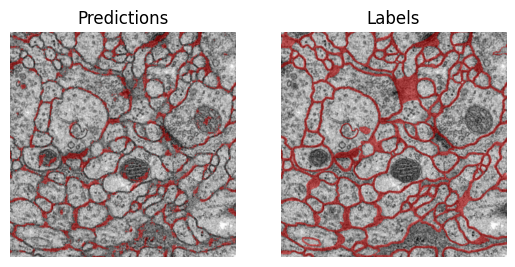

In [10]:
def segment_slice(x, net, window_size, batch_size):

    # setup data loader
    x_orig = x
    ds = EMWindowDataset(x[np.newaxis, ...], np.zeros_like(x[np.newaxis, ...]), window_size, x.size)
    loader = DataLoader(ds, batch_size=batch_size)
    
    # set the network in training mode
    net.eval()
    
    # keep track of the loss and predictions
    preds = np.zeros((len(loader.dataset), 2))
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, _ = data

        # transfer data to GPU and correct format
        x = x.float().to(device)
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)

        # get the class probability predictions and save them for validation
        y_ = torch.softmax(y_pred, dim=1)
        b = i * loader.batch_size
        preds[b: b + y_.size(0), :] = y_.detach().cpu().numpy()
    
    # compute the segmentation
    preds = preds.argmax(axis=1)
    segmentation = np.reshape(preds, x_orig.shape)

    return segmentation.astype('uint8')

# load the best parameters
state_dict = torch.load('cnn_best.cpt')
net.load_state_dict(state_dict)

# perform segmentation
n = 0
t = time.time()
y_pred = segment_slice(x_test[n], net, window_size, batch_size)
print('Elapsed time: %.2f seconds' % (time.time() - t))

# show example
x_overlay = overlay(x_test[n], 1 - y_test[n], colors=[(1, 0, 0)], alpha=0.4)
x_pred_overlay = overlay(x_test[n], 1 - y_pred, colors=[(1, 0, 0)], alpha=0.4)
plt.subplot(1, 2, 1)
plt.imshow(x_pred_overlay)
plt.title('Predictions')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_overlay)
plt.title('Labels')
plt.axis('off')
plt.show()

Visually, the segmentation result does not look perfect. Clearly, the network is making lots of mistakes, especially along membranes, because these regions require more context. 

Another disadvantage to this methodology is the computational inefficiency. Even with larger batches, segmentation of a relatively small image patch can take seconds, which is impractical for larger datasets. The reason is obviously that for each pixel, a forward call of the network is required. 

## 4. Building a U-Net with PyTorch

The lack of global context and computational efficiency of the pixel classification approach results in poor practical performance. As an alternative, the [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) network was proposed. This is an end-to-end segmentation network that takes an image as input and computes a complete segmentation of the input. Let's start by defining the network architecture: 

![U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

**Exercise**: Implement the U-Net architecture: 
- The architecture consists of an encoder, a bottleneck, a decoder and skip connections between the encoder and decoder. 
- The basic building blocks of the U-Net architecture are two consecutive convolutional layers with ReLU activation that take $n$ feature maps and output $m$ feature maps. The convolutional layers have $3 \times 3$ kernels. For simplicity we will also pad the inputs by 1 pixel to make sure the inputs and outputs have the same size. Implement this block in the `ConvBlock` class. 
- Downsampling is relatively simply with $2 \times 2$ max-pooling. However, upsampling is performed using bilinear upsampling layers, followed by a convolution layer. This operation has been implemented in the [`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) class with $2 \times 2$ kernels and a stride of $2$. 
- Implement the skip connections by using the PyTorch [concatenation](https://pytorch.org/docs/stable/generated/torch.cat.html) function. 
- The initial number of feature maps is a parameter that can be chosen. From then on, the amount of feature maps doubles with every `ConvBlock` in the encoder and halves with every `ConvBlock` in the decoder. 

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.unit = nn.Sequential()
        self.unit.add_module('conv1', ConvNormRelu(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
        self.unit.add_module('conv2', ConvNormRelu(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, inputs):
        return self.unit(inputs)

class UNet(nn.Module):
    def __init__(self, feature_maps=16, out_channels=2):
        super(UNet, self).__init__()

        self.feature_maps = feature_maps

        # encoder layers
        self.conv_enc_1 = ConvBlock(in_channels=1, out_channels=feature_maps)
        self.conv_enc_2 = ConvBlock(in_channels=feature_maps, out_channels=2*feature_maps)
        self.conv_enc_3 = ConvBlock(in_channels=2*feature_maps, out_channels=4*feature_maps)
        self.conv_enc_4 = ConvBlock(in_channels=4*feature_maps, out_channels=8*feature_maps)
        self.pool = nn.MaxPool2d(2, 2)

        # bottleneck layers
        self.conv_btl = ConvBlock(in_channels=8*feature_maps, out_channels=16*feature_maps)

        # decoder layers
        self.conv_dec_4_up = nn.ConvTranspose2d(in_channels=16*feature_maps, out_channels=8*feature_maps, kernel_size=2, stride=2)
        self.conv_dec_4 = ConvBlock(in_channels=16*feature_maps, out_channels=8*feature_maps)
        self.conv_dec_3_up = nn.ConvTranspose2d(in_channels=8*feature_maps, out_channels=4*feature_maps, kernel_size=2, stride=2)
        self.conv_dec_3 = ConvBlock(in_channels=8*feature_maps, out_channels=4*feature_maps)
        self.conv_dec_2_up = nn.ConvTranspose2d(in_channels=4*feature_maps, out_channels=2*feature_maps, kernel_size=2, stride=2)
        self.conv_dec_2 = ConvBlock(in_channels=4*feature_maps, out_channels=2*feature_maps)
        self.conv_dec_1_up = nn.ConvTranspose2d(in_channels=2*feature_maps, out_channels=feature_maps, kernel_size=2, stride=2)
        self.conv_dec_1 = ConvBlock(in_channels=2*feature_maps, out_channels=feature_maps)

        # final segmentation layer
        self.conv_final = nn.Conv2d(in_channels=feature_maps, out_channels=out_channels, kernel_size=1)

    def forward(self, x):

        # encoder path
        x1 = self.conv_enc_1(x)
        x = self.pool(x1)
        x2 = self.conv_enc_2(x)
        x = self.pool(x2)
        x3 = self.conv_enc_3(x)
        x = self.pool(x3)
        x4 = self.conv_enc_4(x)
        x = self.pool(x4)

        # bottleneck
        x = self.conv_btl(x)

        # decoder path
        x = torch.cat((self.conv_dec_4_up(x), x4), dim=1)
        x = self.conv_dec_4(x)
        x = torch.cat((self.conv_dec_3_up(x), x3), dim=1)
        x = self.conv_dec_3(x)
        x = torch.cat((self.conv_dec_2_up(x), x2), dim=1)
        x = self.conv_dec_2(x)
        x = torch.cat((self.conv_dec_1_up(x), x1), dim=1)
        x = self.conv_dec_1(x)

        # final segmentation
        x = self.conv_final(x)

        return x


net = UNet(feature_maps=64)
print(net)

UNet(
  (conv_enc_1): ConvBlock(
    (unit): Sequential(
      (conv1): ConvNormRelu(
        (unit): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
      )
      (conv2): ConvNormRelu(
        (unit): Sequential(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
      )
    )
  )
  (conv_enc_2): ConvBlock(
    (unit): Sequential(
      (conv1): ConvNormRelu(
        (unit): Sequential(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
      )
      (conv2): Co

Of course, this network requires an image as input and the corresponding label image as output. Therefore, we have to modify our dataset. 

**Exercise**: Modify the `EMWindowDataset` class: 
- Implement the `__getitem__` method, the remaining functions have already been implemented. 

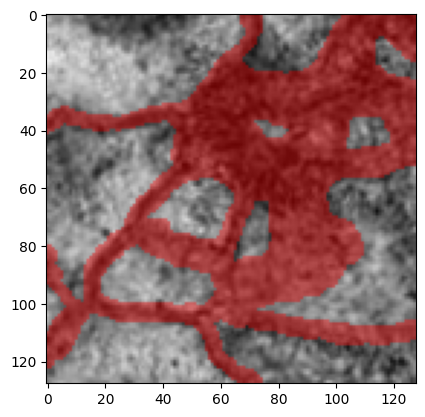

In [12]:
# dataset useful for sampling
class EMWindowDataset(data.Dataset):
    
    def __init__(self, x, y, wnd_sz, max_iter_epoch):

        # window size
        self.wnd_sz = wnd_sz

        # maximum number of iterations per epoch
        self.max_iter_epoch = max_iter_epoch

        # save the data
        self.x = x

        # save the labels
        self.y = y
    
    def __getitem__(self, i):

        # generate random location in the data
        z = np.random.randint(self.x.shape[0])
        y = np.random.randint(self.x.shape[1] - self.wnd_sz[0] + 1)
        x = np.random.randint(self.x.shape[2] - self.wnd_sz[1] + 1)

        # extract the input and label windows
        wnd_x = self.x[z:z + 1, y:y + self.wnd_sz[0], x:x + self.wnd_sz[1]]
        wnd_y = self.y[z:z + 1, y:y + self.wnd_sz[0], x:x + self.wnd_sz[1]]

        return wnd_x, wnd_y
    
    def __len__(self):
        return self.max_iter_epoch

# parameters
window_size = (128, 128)
batch_size = 2
max_iter_epoch = 128

# make an instance of the dataset for training and testing
ds_train = EMWindowDataset(x_train, y_train, window_size, max_iter_epoch)
ds_test = EMWindowDataset(x_test, y_test, window_size, max_iter_epoch)

# test the class
n = np.random.randint(len(ds_train))
x, y = ds_train[n]
x_overlay = overlay(x[0], 1 - y[0], colors=[(1, 0, 0)], alpha=0.4)
plt.imshow(x_overlay)
plt.show()

# setup the data loader
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

## 5. Training & validating the network

Now that we have a U-Net network and a data loader, it is time to train the network! For the sake of repetitiveness, you are not required to implement the complete training loop. 

**Exercise**: Train the U-Net architecture: 
- Have a look at the training loop code and identify the differences with classical CNN training. 
- Train the network for 20 epochs with a learning rate of 0.001. 

Epoch     0 - Train loss: 0.383133 - Test loss: 0.354965 - Test dice avg: 0.856172
Epoch     1 - Train loss: 0.361292 - Test loss: 0.352362 - Test dice avg: 0.902300
Epoch     2 - Train loss: 0.324768 - Test loss: 0.306067 - Test dice avg: 0.887419
Epoch     3 - Train loss: 0.325949 - Test loss: 0.334848 - Test dice avg: 0.850665
Epoch     4 - Train loss: 0.328289 - Test loss: 0.310259 - Test dice avg: 0.913652
Epoch     5 - Train loss: 0.315503 - Test loss: 0.305358 - Test dice avg: 0.878493
Epoch     6 - Train loss: 0.316873 - Test loss: 0.324832 - Test dice avg: 0.908888
Epoch     7 - Train loss: 0.303972 - Test loss: 0.295798 - Test dice avg: 0.932093
Epoch     8 - Train loss: 0.305955 - Test loss: 0.300341 - Test dice avg: 0.886833
Epoch     9 - Train loss: 0.288136 - Test loss: 0.260361 - Test dice avg: 0.931314
Epoch    10 - Train loss: 0.273979 - Test loss: 0.266878 - Test dice avg: 0.914591
Epoch    11 - Train loss: 0.282206 - Test loss: 0.261618 - Test dice avg: 0.903781
Epoc

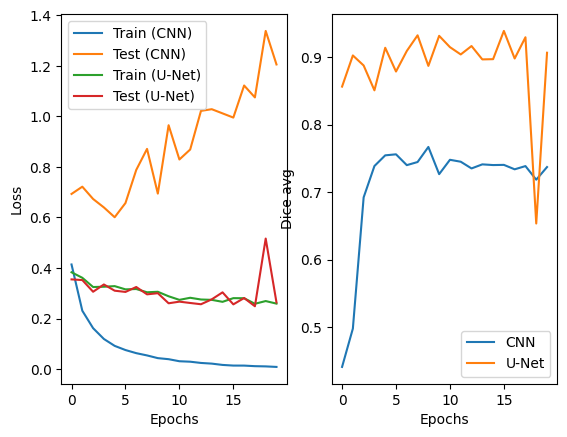

In [13]:
# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer):
    
    # set the network in training mode
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data

        # transfer data to GPU and correct format
        x = x.float().to(device)
        y = y.long()[:, 0, :, :].to(device)
        
        # set all gradients equal to zero
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
        
        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in training mode
    net.eval()
    
    # keep track of the loss and predictions
    preds = np.zeros((len(loader.dataset), *loader.dataset.wnd_sz))
    ys = np.zeros((len(loader.dataset), *loader.dataset.wnd_sz))
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data

        # transfer data to GPU and correct format
        x = x.float().to(device)
        y = y.long()[:, 0, :, :].to(device)
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # get the class probability predictions and save them for validation
        y_ = torch.softmax(y_pred, dim=1)
        b = i * loader.batch_size
        preds[b: b + y_.size(0), ...] = y_.argmax(dim=1).detach().cpu().numpy()
        ys[b: b + y_.size(0), ...] = y.detach().cpu().numpy()
    
    # compute accuracy
    d = dice(ys.flatten(), preds.flatten())
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg, d

def train_net(net, train_loader, test_loader, loss_fn, optimizer, epochs, log_dir):
    
    # transfer the network to the GPU
    net.to(device)
    
    best_dice = 0
    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    test_dice = np.zeros((epochs))
    for epoch in range(epochs):
        
        # training
        train_loss[epoch] = train_epoch(net, train_loader, loss_fn, optimizer)
        
        # testing
        test_loss[epoch], test_dice[epoch] = test_epoch(net, test_loader, loss_fn)

        # check if accuracy has increased
        if test_dice[epoch] > best_dice: 
            best_dice = test_dice[epoch]

            # save the model
            torch.save(net.state_dict(), 'unet_best.cpt')
        
        print('Epoch %5d - Train loss: %.6f - Test loss: %.6f - Test dice avg: %.6f' % (epoch, train_loss[epoch], test_loss[epoch], test_dice[epoch]))
    
    return train_loss, test_loss, test_dice


# parameters
learning_rate = 0.001
n_epochs = 20
log_dir = '.'

# define the optimizer
class_weights = torch.from_numpy(np.divide(1, class_distribution)).float().to(device)
class_weights = class_weights / class_weights.sum()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# start training
train_loss_unet, test_loss_unet, test_dice_unet = train_net(net, train_loader, test_loader, loss_fn, optimizer, n_epochs, log_dir)

# show the training curve and accuracy
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn)
plt.plot(test_loss_cnn)
plt.plot(train_loss_unet)
plt.plot(test_loss_unet)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(('Train (CNN)', 'Test (CNN)', 'Train (U-Net)', 'Test (U-Net)'))
plt.subplot(1, 2, 2)
plt.plot(test_dice_cnn)
plt.plot(test_dice_unet)
plt.xlabel('Epochs')
plt.ylabel('Dice avg')
plt.legend(('CNN', 'U-Net'))
plt.show()

That should look much better! The U-Net architecture is significantly less suffering from overfitting and the mean Dice coefficient is substantially higher (should be approximately 0.90). 

Now let's have a look how the actual predictions look like. 

**Exercise**: Modify the `segment_slice` so that it segments a 2D image with a U-Net network: 
- Simplify the original code of `segment_slice` by propagating the image straightforward through the network. 
- Can you figure out why alternative image sizes can also be fed into the network? Is that always possible? 

Elapsed time: 0.10 seconds


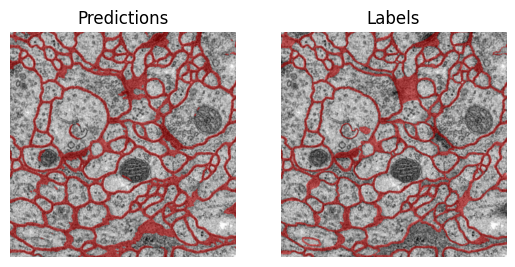

In [14]:
def segment_slice(x, net):
    
    # set the network in training mode
    net.eval()

    # convert to torch tensor
    x = torch.from_numpy(x[np.newaxis, np.newaxis, ...]).float().to(device)

    # forward propagation
    pred = net(x).detach().cpu().numpy()
    
    # compute the segmentation
    segmentation = pred.argmax(axis=1)[0]

    return segmentation

# load the best parameters
state_dict = torch.load('unet_best.cpt')
net.load_state_dict(state_dict)

# perform segmentation
n = 0
t = time.time()
y_pred = segment_slice(x_test[n], net)
print('Elapsed time: %.2f seconds' % (time.time() - t))

# show example
x_overlay = overlay(x_test[n], 1 - y_test[n], colors=[(1, 0, 0)], alpha=0.4)
x_pred_overlay = overlay(x_test[n], 1 - y_pred, colors=[(1, 0, 0)], alpha=0.4)
plt.subplot(1, 2, 1)
plt.imshow(x_pred_overlay)
plt.title('Predictions')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_overlay)
plt.title('Labels')
plt.axis('off')
plt.show()

That is a much more usable segmentation result! Also note how much faster the segmentation computation is. The U-Net architecture excells in biomedical datasets because it can cope relatively well with small amounts of training data. If you have time left, you can always try to improve the results by adding data augmentation! 